# Final Project Submission

* Students names: Cody Freese/Fennec Nightingale/Thomas Cornett
* Student pace: Part time
* Instructor name: Amber Yandow
* Blog post URL:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>

<font size=3rem>
    
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
</font>
___

# INTRODUCTION

## Words go here lol

# OBTAIN

## Import tools

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import mlxtend
from scipy.stats import zscore
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.max_rows = 4000
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

## King County dataset

In [180]:
# read data
kc_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 
              'sqft_basement', 'yr_built']

kc_dtypes = {'id': int, 'date' : str,  'price': float, 'bedrooms' : int, 'bathrooms' : float, 'sqft_living': int, 'sqft_lot': int, 
             'floors': float, 'waterfront': float, 'view' : float, 'condition': float, 'grade': int, 'sqft_above': int, 
             'yr_built': int, 'yr_renovated': float, 'zipcode': float, 'lat': float, 'long': float}

kc_data = pd.read_csv('kc_house_data.csv', dtype = kc_dtypes, parse_dates = ['date'])

kc_data['sqft_basement'] = kc_data['sqft_basement'].replace({'?': 0})
kc_data['sqft_basement'] = kc_data['sqft_basement'].astype(dtype=float, errors='ignore')
kc_data['sqft_total'] = kc_data['sqft_living']*kc_data['sqft_lot']
kc_data['sqft_habitable'] = (kc_data['sqft_above']+1)*(kc_data['sqft_basement']+1)

In [181]:
#drop unnessecary columns and fix data
kc_data = kc_data.drop('sqft_living', 1).drop('sqft_lot', 1).drop('id', 1).drop('date', 1).drop('sqft_above',1).drop('sqft_basement',1)

#look for outliers, in bedrooms, we can clearly see a single outlier, for other columns, filtering by z score will be easiest 
kc_data[kc_data['bedrooms'] == 33]
# wouldn't be realistic for a house with 33 bedrooms to only have a sqft_living of 1620 and only 1 3/4 bathrooms so it looks like a typo
# will adjust to 3 
kc_data[kc_data['bedrooms'] == 33] = kc_data[kc_data['bedrooms'] == 33].replace(33,3)

In [182]:
#setting waterfront NaN values equal to the ratio of waterfront/non-waterfront properties, will want to try and narrow by zipcode 
#filling NaN with easily seperatable/changable values helpful 
kc_data['waterfront'] = kc_data['waterfront'].fillna(146/19221)
kc_data['view'] = kc_data['view'].fillna(0)
kc_data['yr_renovated'] = kc_data['yr_renovated'].fillna(0)

In [183]:
#Convert to integer for whole number year
kc_data['yr_renovated'] = kc_data['yr_renovated'].astype('int')

In [184]:
dumm = pd.get_dummies(kc_data['condition'], prefix='cond', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)
dumm = pd.get_dummies(kc_data['view'], prefix='view', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)
dumm = pd.get_dummies(kc_data['grade'], prefix='gra', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)

In [185]:
kc_data = kc_data.rename({'cond_2.0':'con2', 'cond_3.0':'con3','cond_4.0':'con4','cond_5.0':'con5'},axis=1)
kc_data = kc_data.rename({ 'view_1.0': 'view1', 'view_2.0': 'view2', 'view_3.0': 'view3', 'view_4.0':'view4'},axis=1)
kc_data = kc_data.rename({ 'gra_4': 'grd4', 'gra_5':'grd5', 'gra_6':'grd6',
       'gra_7':'grd7', 'gra_8':'grd8', 'gra_9':'grd9', 'gra_10':'grd10', 'gra_11':'grd11', 'gra_12':'grd12', 'gra_13':'grd13'},axis=1)

# SCRUB

## Dataframe Info

In [125]:
kc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 35 columns):
price             21597 non-null float64
bedrooms          21597 non-null int32
bathrooms         21597 non-null float64
floors            21597 non-null float64
waterfront        21597 non-null float64
view              21597 non-null float64
condition         21597 non-null float64
grade             21597 non-null int32
yr_built          21597 non-null int32
yr_renovated      21597 non-null int32
zipcode           21597 non-null float64
lat               21597 non-null float64
long              21597 non-null float64
sqft_living15     21597 non-null int64
sqft_lot15        21597 non-null int64
sqft_total        21597 non-null int32
sqft_habitable    21597 non-null float64
con2              21597 non-null int32
con3              21597 non-null int32
con4              21597 non-null int32
con5              21597 non-null int32
view1             21597 non-null int32
view2        

## Check for NaN

In [126]:
kc_data.isna().sum()

price             0
bedrooms          0
bathrooms         0
floors            0
waterfront        0
view              0
condition         0
grade             0
yr_built          0
yr_renovated      0
zipcode           0
lat               0
long              0
sqft_living15     0
sqft_lot15        0
sqft_total        0
sqft_habitable    0
con2              0
con3              0
con4              0
con5              0
view1             0
view2             0
view3             0
view4             0
grd4              0
grd5              0
grd6              0
grd7              0
grd8              0
grd9              0
grd10             0
grd11             0
grd12             0
grd13             0
dtype: int64

## For Loop - Value Counts

In [127]:
for col in kc_data.columns:
    try:
        print(col, kc_data[col].value_counts()[:5])
    except:
        print(col, kc_data[col].value_counts())
    print('\n')

price 350000.0     172
450000.0     172
550000.0     159
500000.0     152
425000.0     150
325000.0     148
400000.0     145
375000.0     138
300000.0     133
525000.0     131
250000.0     130
475000.0     120
330000.0     119
650000.0     117
275000.0     113
415000.0     111
315000.0     111
390000.0     110
600000.0     110
440000.0     109
280000.0     109
320000.0     107
435000.0     105
340000.0     103
310000.0     101
335000.0      98
420000.0      97
360000.0      96
260000.0      95
265000.0      94
575000.0      93
625000.0      93
305000.0      92
380000.0      92
430000.0      91
530000.0      91
345000.0      91
270000.0      90
465000.0      89
245000.0      89
700000.0      89
290000.0      88
490000.0      88
370000.0      88
750000.0      87
255000.0      86
410000.0      86
385000.0      86
355000.0      86
230000.0      85
225000.0      83
515000.0      83
485000.0      82
480000.0      81
285000.0      80
235000.0      80
240000.0      79
405000.0      79
365000.0

## Drop Condition Has No Values Present

In [128]:
kc_data = kc_data.drop('con3', axis=1).drop('grd13', axis=1)

## Summary

In [129]:
kc_data.describe().round(3)

price   bedrooms  bathrooms     floors  waterfront       view  \
count    21597.000  21597.000  21597.000  21597.000   21597.000  21597.000   
mean    540296.574      3.372      2.116      1.494       0.008      0.233   
std     367368.140      0.904      0.769      0.540       0.082      0.765   
min      78000.000      1.000      0.500      1.000       0.000      0.000   
25%     322000.000      3.000      1.750      1.000       0.000      0.000   
50%     450000.000      3.000      2.250      1.500       0.000      0.000   
75%     645000.000      4.000      2.500      2.000       0.000      0.000   
max    7700000.000     11.000      8.000      3.500       1.000      4.000   

       condition      grade   yr_built  yr_renovated  ...      view4  \
count  21597.000  21597.000  21597.000     21597.000  ...  21597.000   
mean       3.410      7.658   1971.000        68.758  ...      0.015   
std        0.651      1.173     29.375       364.037  ...      0.120   
min        1.000      3.000   1900.000         0.000  ...      0.000   
25%        3.000      7.000   1951.000         0.000  ...      0.000   
50%        3.000      7.000   1975.000         0.000  ...      0.000   
75%        4.000      8.000   1997.000         0.000  ...      0.000   
max        5.000     13.000   2015.000      2015.000  ...      1.000   

            grd4       grd5       grd6       grd7       grd8       grd9  \
count  21597.000  21597.000  21597.000  21597.000  21597.000  21597.000   
mean       0.001      0.011      0.094      0.416      0.281      0.121   
std        0.035      0.105      0.292      0.493      0.449      0.326   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        0.000      0.000      0.000      0.000      0.000      0.000   
50%        0.000      0.000      0.000      0.000      0.000      0.000   
75%        0.000      0.000      0.000      1.000      1.000      0.000   
max        1.000      1.000      1.000      1.000      1.000      1.000   

           grd10      grd11      grd12  
count  21597.000  21597.000  21597.000  
mean       0.053      0.018      0.004  
std        0.223      0.135      0.064  
min        0.000      0.000      0.000  
25%        0.000      0.000      0.000  
50%        0.000      0.000      0.000  
75%        0.000      0.000      0.000  
max        1.000      1.000      1.000  

[8 rows x 33 columns]

# EXPLORE

## Histogram

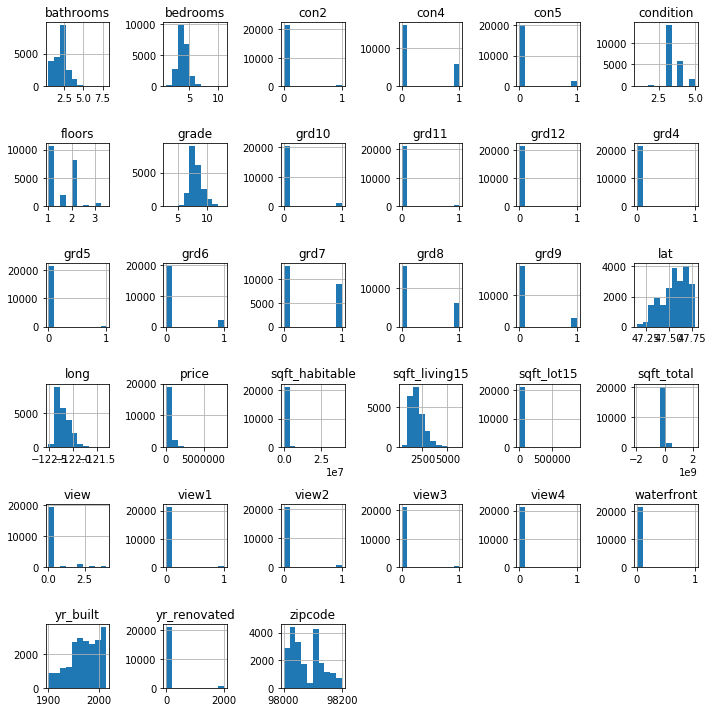

In [130]:
kc_data.hist(figsize=(10,10))
plt.tight_layout()

## Scatter Matrix

In [131]:
# fig = pd.plotting.scatter_matrix(kc_data,figsize=(16,16));
# print(type(fig))

## Heatmap

Text(0.5, 1, 'Correlations')

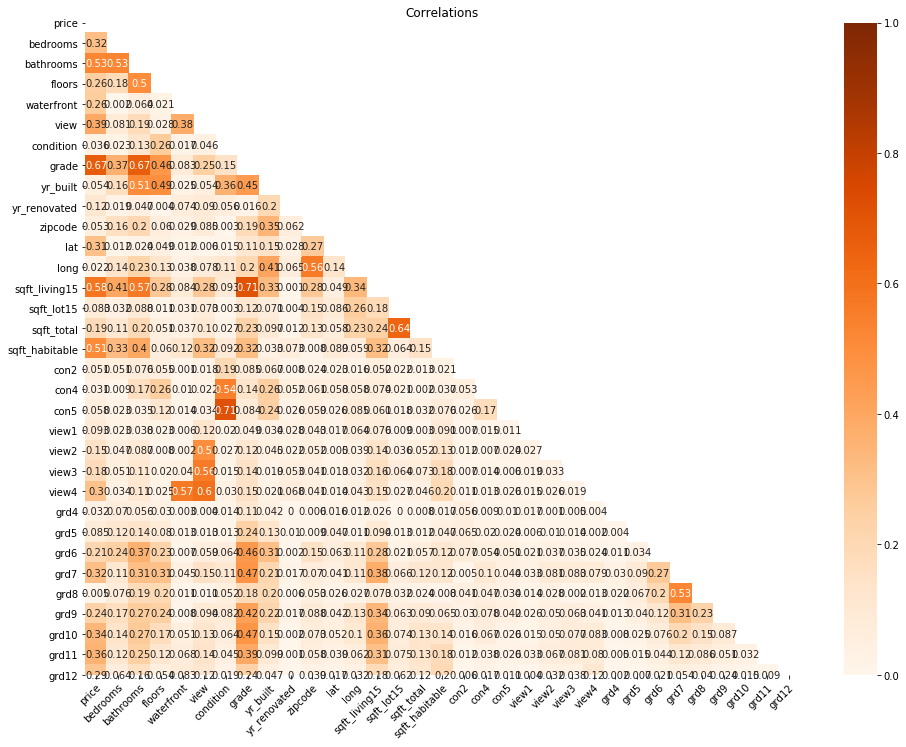

In [132]:
fig, ax = plt.subplots(figsize=(16,12))

corr = kc_data.corr().abs().round(3)

mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, annot=True, mask=mask, cmap='Oranges', ax=ax)
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
ax.set_title('Correlations')

# MODEL

## Initial Model on Price

In [186]:
outcome = 'price'
x_cols = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'sqft_total', 'sqft_habitable',
       'con2', 'con4', 'con5', 'view1', 'view2', 'view3', 'view4', 'grd4',
       'grd5', 'grd6', 'grd7', 'grd8', 'grd9', 'grd10', 'grd11', 'grd12']

In [187]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=kc_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     2023.
Date:                Wed, 09 Dec 2020   Prob (F-statistic):               0.00
Time:                        20:07:19   Log-Likelihood:            -2.9377e+05
No. Observations:               21597   AIC:                         5.876e+05
Df Residuals:                   21569   BIC:                         5.878e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       3.017e+07   2.77e+06     10.884      0.000    2.47e+07    3.56e+07
bedrooms        6641.2895   1809.278      3.671      0.000    3094.971    1.02e+04
bathrooms       7.269e+04   3009.868     24.151      0.000    6.68e+04    7.86e+04
floors          4.929e+04   3291.983     14.972      0.000    4.28e+04    5.57e+04
waterfront      5.618e+05   1.98e+04     28.303      0.000    5.23e+05    6.01e+05
view            5.407e+04   2215.353     24.408      0.000    4.97e+04    5.84e+04
yr_built       -2401.9123     71.217    -33.727      0.000   -2541.502   -2262.323
yr_renovated      32.3107      3.882      8.322      0.000      24.701      39.921
zipcode         -635.0498     32.113    -19.775      0.000    -697.994    -572.105
lat             5.985e+05   1.04e+04     57.495      0.000    5.78e+05    6.19e+05
long           -8.812e+04   1.23e+04     -7.152      0.000   -1.12e+05    -6.4e+04
sqft_total      2.751e-05   1.31e-05      2.092      0.036    1.74e-06    5.33e-05
sqft_habitable     0.0571      0.002     35.005      0.000       0.054       0.060
con2           -1.222e+04   1.53e+04     -0.800      0.424   -4.21e+04    1.77e+04
con4            2.924e+04   3386.859      8.635      0.000    2.26e+04    3.59e+04
con5            6.369e+04   5395.944     11.803      0.000    5.31e+04    7.43e+04
view1           7.443e+04   1.07e+04      6.955      0.000    5.35e+04    9.54e+04
view2          -3.177e+04   6782.040     -4.685      0.000   -4.51e+04   -1.85e+04
view3          -3.067e+04   8105.674     -3.784      0.000   -4.66e+04   -1.48e+04
view4            3.38e+04   7524.473      4.492      0.000    1.91e+04    4.86e+04
grd4           -2.372e+06   6.59e+04    -35.974      0.000    -2.5e+06   -2.24e+06
grd5           -2.371e+06   5.55e+04    -42.724      0.000   -2.48e+06   -2.26e+06
grd6           -2.322e+06   5.42e+04    -42.870      0.000   -2.43e+06   -2.22e+06
grd7           -2.258e+06   5.38e+04    -41.939      0.000   -2.36e+06   -2.15e+06
grd8            -2.16e+06   5.37e+04    -40.230      0.000   -2.27e+06   -2.05e+06
grd9           -1.971e+06   5.37e+04    -36.714      0.000   -2.08e+06   -1.87e+06
grd10          -1.752e+06   5.37e+04    -32.617      0.000   -1.86e+06   -1.65e+06
grd11          -1.446e+06   5.41e+04    -26.742      0.000   -1.55e+06   -1.34e+06
grd12          -9.609e+05   5.67e+04    -16.941      0.000   -1.07e+06    -8.5e+05
==============================================================================
Omnibus:                    13502.023   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           694896.509
Skew:                           2.340   Prob(JB):                         0.00
Kurtosis:                      30.392   Cond. No.                     1.05e+16
================================

## Regression Results

In [188]:
model.params.sort_values()

grd4             -2.371916e+06
grd5             -2.370804e+06
grd6             -2.321864e+06
grd7             -2.257956e+06
grd8             -2.160166e+06
grd9             -1.970724e+06
grd10            -1.751779e+06
grd11            -1.446165e+06
grd12            -9.608800e+05
long             -8.811793e+04
view2            -3.177219e+04
view3            -3.067267e+04
con2             -1.221597e+04
yr_built         -2.401912e+03
zipcode          -6.350498e+02
sqft_total        2.750954e-05
sqft_habitable    5.709188e-02
yr_renovated      3.231072e+01
bedrooms          6.641289e+03
con4              2.924453e+04
view4             3.380150e+04
floors            4.928663e+04
view              5.407131e+04
con5              6.369062e+04
bathrooms         7.269071e+04
view1             7.442768e+04
waterfront        5.617862e+05
lat               5.985185e+05
Intercept         3.016853e+07
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                          1.290e+04
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                        0.00
Time:                        20:07:21   Log-Likelihood:                         -54455.
No. Observations:                4561   AIC:                                  1.089e+05
Df Residuals:                    4546   BIC:                                  1.090e+05
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms        2729.6298    828.956      3.293      0.001    1104.474    4354.786
bathrooms       2.229e+04   1339.933     16.636      0.000    1.97e+04    2.49e+04
floors          8880.2329   1679.977      5.286      0.000    5586.662    1.22e+04
waterfront      1.009e+05   2.63e+04      3.837      0.000    4.94e+04    1.52e+05
zipcode          -36.1396      6.491     -5.568      0.000     -48.865     -23.414
lat             1.134e+05   5319.035     21.319      0.000    1.03e+05    1.24e+05
long             1.35e+04   4535.989      2.976      0.003    4605.061    2.24e+04
sqft_total         0.0001      2e-05      5.346      0.000    6.76e-05       0.000
sqft_habitable     0.0115      0.002      6.085      0.000       0.008       0.015
con4            7995.1006   1263.870      6.326      0.000    5517.302    1.05e+04
con5            1.417e+04   2272.698      6.235      0.000    9715.562    1.86e+04
view1           3.317e+04   1.03e+04      3.208      0.001    1.29e+04    5.35e+04
grd4           -6.085e+04   8250.524     -7.375      0.000    -7.7e+04   -4.47e+04
grd5           -4.096e+04   2965.700    -13.811      0.000   -4.68e+04   -3.51e+04
grd6           -1.619e+04   1463.792    -11.062      0.000   -1.91e+04   -1.33e+04
==============================================================================
Omnibus:                      244.200   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              287.168
Skew:                          -0.575   Prob(JB):                     4.39e-63
Kurtosis:                       3.434   Cond. No.                     1.51e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          2.218e+04
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                        0.00
Time:                        20:07:21   Log-Likelihood:                     -1.8233e+05
No. Observations:               14093   AIC:                                  3.647e+05
Df Residuals:                   14077   BIC:                                  3.648e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       4.453e+04   1778.651     25.036      0.000     4.1e+04     4.8e+04
waterfront      8.245e+04   1.83e+04      4.506      0.000    4.66e+04    1.18e+05
view            2.248e+04   1480.489     15.187      0.000    1.96e+04    2.54e+04
yr_built       -1609.8439     41.644    -38.657      0.000   -1691.472   -1528.215
zipcode          -44.1154     10.504     -4.200      0.000     -64.705     -23.525
lat             3.633e+05   7069.581     51.385      0.000    3.49e+05    3.77e+05
long            7.783e+04   7848.930      9.915      0.000    6.24e+04    9.32e+04
sqft_habitable     0.0087      0.001      6.389      0.000       0.006       0.011
con4            1.256e+04   2120.849      5.922      0.000    8402.765    1.67e+04
con5            3.154e+04   3473.271      9.081      0.000    2.47e+04    3.83e+04
view1           3.679e+04   7307.448      5.034      0.000    2.25e+04    5.11e+04
grd7            6.005e+04   3749.345     16.016      0.000    5.27e+04    6.74e+04
grd8            1.416e+05   4151.330     34.105      0.000    1.33e+05     1.5e+05
grd9            2.463e+05   4828.781     50.996      0.000    2.37e+05    2.56e+05
grd10           3.147e+05   6772.669     46.469      0.000    3.01e+05    3.28e+05
grd11           3.338e+05    2.2e+04     15.204      0.000    2.91e+05    3.77e+05
==============================================================================
Omnibus:                      369.930   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              399.138
Skew:                           0.411   Prob(JB):                     2.13e-87
Kurtosis:                       3.066   Cond. No.                     2.09e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                              1997.
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                        0.00
Time:                        20:07:21   Log-Likelihood:                         -41869.
No. Observations:                2943   AIC:                                  8.377e+04
Df Residuals:                    2925   BIC:                                  8.388e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       1.345e+05    1.1e+04     12.223      0.000    1.13e+05    1.56e+05
waterfront      7.929e+05   3.64e+04     21.763      0.000    7.21e+05    8.64e+05
yr_built       -1658.6813    298.585     -5.555      0.000   -2244.140   -1073.223
yr_renovated      32.2092     13.627      2.364      0.018       5.490      58.928
zipcode        -1944.9679    107.433    -18.104      0.000   -2155.620   -1734.316
lat             8.088e+05   1.04e+05      7.755      0.000    6.04e+05    1.01e+06
long           -1.293e+06   7.72e+04    -16.750      0.000   -1.44e+06   -1.14e+06
sqft_habitable     0.0509      0.004     13.420      0.000       0.043       0.058
con4            6.893e+04   1.82e+04      3.788      0.000    3.33e+04    1.05e+05
con5            7.069e+04    2.5e+04      2.825      0.005    2.16e+04     1.2e+05
view1           7.051e+04   3.47e+04      2.034      0.042    2549.005    1.38e+05
grd4            7.171e-09   4.11e-10     17.429      0.000    6.36e-09    7.98e-09
grd6           -2.028e+06   1.55e+05    -13.044      0.000   -2.33e+06   -1.72e+06
grd7            -2.12e+06   1.12e+05    -18.978      0.000   -2.34e+06    -1.9e+06
grd8            -2.06e+06   1.08e+05    -19.083      0.000   -2.27e+06   -1.85e+06
grd9           -1.917e+06   1.07e+05    -17.964      0.000   -2.13e+06   -1.71e+06
grd10          -1.715e+06   1.06e+05    -16.117      0.000   -1.92e+06   -1.51e+06
grd11          -1.498e+06   1.07e+05    -14.066      0.000   -1.71e+06   -1.29e+06
grd12          -1.049e+06   1.11e+05     -9.487      0.000   -1.27e+06   -8.32e+05
==============================================================================
Omnibus:                     1099.814   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9465.762
Skew:                           1.531   Prob(JB):                         0.00
Kurtosis:                      11.235   Cond. No.                     2.67e+23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.65e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

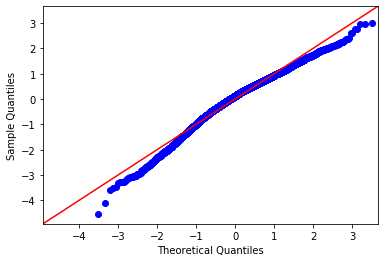

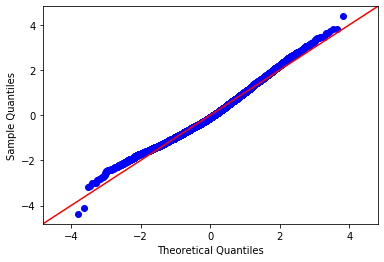

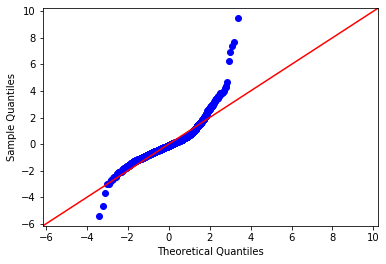

In [189]:
lowtier = kc_data[kc_data.price <=300000]
midtier = kc_data[(kc_data.price > 300001) & (kc_data.price<=800000) ]
hightier = kc_data[kc_data.price >800000]

lowincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'zipcode', 'lat',
       'long', 'sqft_total', 'sqft_habitable', 'con4', 'con5', 'view1', 'grd4',
       'grd5', 'grd6']

mediumincome = ['bathrooms', 'waterfront', 'view', 'yr_built',
                  'zipcode', 'lat','long', 'sqft_habitable',
                   'con4', 'con5', 'view1','grd7', 'grd8', 'grd9', 
                  'grd10', 'grd11']
highincome = [ 'bathrooms', 'waterfront','yr_built', 
                   'yr_renovated', 'zipcode', 'lat','long', 'sqft_habitable',
                   'con4', 'con5', 'view1', 'grd4', 'grd6',
                   'grd7', 'grd8', 'grd9', 'grd10', 'grd11', 'grd12']

def make_ols(df, x_columns, drops=None, target='price', add_constant=False):
    if drops:
        drops.append(target)
        X = df.drop(columns=drops)
    else:
        X = df[x_columns]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X)
    res = ols.fit()
    display(res.summary())
    fig = sm.graphics.qqplot(res.resid, dist=stats.norm, line='45', fit=True)
    return res
make_ols(lowtier,lowincome)
make_ols(midtier,mediumincome)
make_ols(hightier,highincome)

## Refinement

In [190]:
kc_columns = ['price']

In [191]:
for col in kc_columns:
    col_zscore = str(col + '_zscore')
    kc_data[col_zscore] = (kc_data[col] - kc_data[col].mean())/kc_data[col].std()
    kc_data = kc_data.loc[kc_data[col_zscore] < 2.25]
    kc_data = kc_data.loc[kc_data[col_zscore] > (-2.25)]
    kc_data = kc_data.drop(col_zscore, axis = 1)

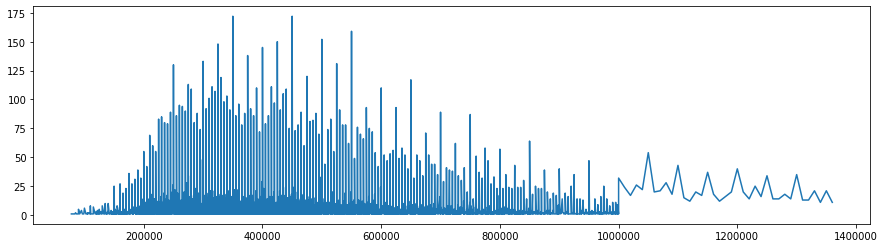

In [192]:
plt.figure(figsize=(15,4))
plt.plot(kc_data['price'].value_counts().sort_index())

In [193]:
for i in range(1,100):
    q = i / 100
    print('{} percentile: {}'.format(q, kc_data['price'].quantile(q=q)))

0.01 percentile: 153000.0
0.02 percentile: 175000.0
0.03 percentile: 190000.0
0.04 percentile: 200000.0
0.05 percentile: 210000.0
0.06 percentile: 218000.0
0.07 percentile: 225000.0
0.08 percentile: 230000.0
0.09 percentile: 239000.0
0.1 percentile: 245000.0
0.11 percentile: 250000.0
0.12 percentile: 254000.0
0.13 percentile: 259900.0
0.14 percentile: 265000.0
0.15 percentile: 269950.0
0.16 percentile: 275000.0
0.17 percentile: 279000.0
0.18 percentile: 284000.0
0.19 percentile: 289056.0
0.2 percentile: 294370.0
0.21 percentile: 299900.0
0.22 percentile: 302949.60000000003
0.23 percentile: 308950.0
0.24 percentile: 313500.0
0.25 percentile: 319000.0
0.26 percentile: 324000.0
0.27 percentile: 326617.36000000034
0.28 percentile: 330000.0
0.29 percentile: 335000.0
0.3 percentile: 340000.0
0.31 percentile: 345000.0
0.32 percentile: 350000.0
0.33 percentile: 355000.0
0.34 percentile: 359950.0
0.35 percentile: 365000.0
0.36 percentile: 370000.0
0.37 percentile: 375000.0
0.38 percentile: 3800

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                          1.372e+04
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                        0.00
Time:                        20:13:03   Log-Likelihood:                         -54471.
No. Observations:                4561   AIC:                                  1.090e+05
Df Residuals:                    4547   BIC:                                  1.091e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms        2489.4538    830.559      2.997      0.003     861.155    4117.753
bathrooms       2.158e+04   1338.190     16.125      0.000     1.9e+04    2.42e+04
floors          9254.5712   1684.159      5.495      0.000    5952.801    1.26e+04
waterfront      1.069e+05   2.64e+04      4.054      0.000    5.52e+04    1.59e+05
lat             9.851e+04   4613.488     21.353      0.000    8.95e+04    1.08e+05
long            3.671e+04   1794.128     20.460      0.000    3.32e+04    4.02e+04
sqft_total       9.42e-05   1.99e-05      4.734      0.000    5.52e-05       0.000
sqft_habitable     0.0129      0.002      6.864      0.000       0.009       0.017
con4            7632.1460   1266.344      6.027      0.000    5149.496    1.01e+04
con5             1.29e+04   2268.607      5.685      0.000    8450.139    1.73e+04
view1           3.356e+04   1.04e+04      3.235      0.001    1.32e+04    5.39e+04
grd4            -6.18e+04   8275.922     -7.467      0.000    -7.8e+04   -4.56e+04
grd5            -4.14e+04   2974.421    -13.917      0.000   -4.72e+04   -3.56e+04
grd6           -1.607e+04   1468.452    -10.945      0.000    -1.9e+04   -1.32e+04
==============================================================================
Omnibus:                      248.541   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              295.233
Skew:                          -0.574   Prob(JB):                     7.78e-65
Kurtosis:                       3.485   Cond. No.                     1.51e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                          4.651e+04
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                        0.00
Time:                        20:13:03   Log-Likelihood:                     -1.2703e+05
No. Observations:               10139   AIC:                                  2.541e+05
Df Residuals:                   10130   BIC:                                  2.541e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms        2.46e+04   1418.667     17.338      0.000    2.18e+04    2.74e+04
yr_built        -934.8135     31.416    -29.756      0.000    -996.395    -873.232
lat              2.11e+05   5008.125     42.132      0.000    2.01e+05    2.21e+05
long             6.44e+04   1981.802     32.496      0.000    6.05e+04    6.83e+04
sqft_habitable     0.0077      0.001      6.337      0.000       0.005       0.010
grd7            3.159e+04   2621.295     12.051      0.000    2.65e+04    3.67e+04
grd8            7.647e+04   3024.909     25.279      0.000    7.05e+04    8.24e+04
grd9            1.237e+05   3955.389     31.264      0.000    1.16e+05    1.31e+05
grd10           1.548e+05   8790.962     17.611      0.000    1.38e+05    1.72e+05
==============================================================================
Omnibus:                      271.662   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.640
Skew:                           0.245   Prob(JB):                     7.34e-44
Kurtosis:                       2.520   Cond. No.                     9.22e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.22e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                          2.634e+04
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                        0.00
Time:                        20:13:03   Log-Likelihood:                         -70375.
No. Observations:                5439   AIC:                                  1.408e+05
Df Residuals:                    5428   BIC:                                  1.408e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       2.984e+04   2660.867     11.213      0.000    2.46e+04    3.51e+04
waterfront      8.427e+04   1.79e+04      4.706      0.000    4.92e+04    1.19e+05
yr_built        -881.5903     56.854    -15.506      0.000    -993.047    -770.133
long           -1.922e+04    897.822    -21.404      0.000    -2.1e+04   -1.75e+04
sqft_habitable     0.0063      0.002      4.142      0.000       0.003       0.009
con4            1.192e+04   3469.597      3.435      0.001    5116.567    1.87e+04
con5            1.432e+04   5119.341      2.796      0.005    4279.109    2.44e+04
view1           1.885e+04   8587.617      2.195      0.028    2016.509    3.57e+04
grd4            4.203e-10   1.13e-10      3.724      0.000    1.99e-10    6.42e-10
grd9            8.141e+04   3598.737     22.622      0.000    7.44e+04    8.85e+04
grd10           1.332e+05   4898.620     27.193      0.000    1.24e+05    1.43e+05
grd11           1.939e+05   1.12e+04     17.321      0.000    1.72e+05    2.16e+05
==============================================================================
Omnibus:                      217.012   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.071
Skew:                           0.496   Prob(JB):                     5.47e-52
Kurtosis:                       2.763   Cond. No.                     2.68e+23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.08e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

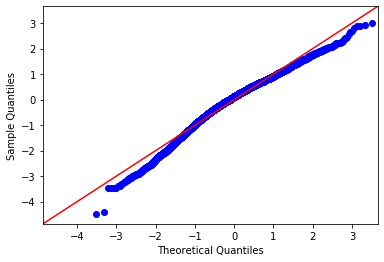

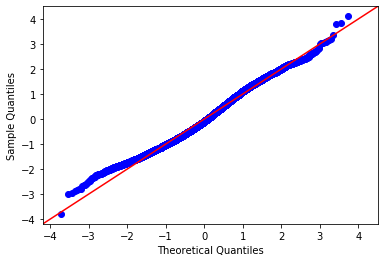

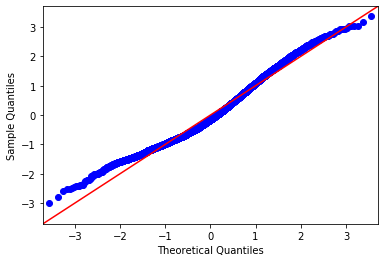

In [206]:
lowtier = kc_data[kc_data.price <=300000]
midtier = kc_data[(kc_data.price > 300000) & (kc_data.price<=575000) ]
hightier = kc_data[(kc_data.price >575000) & (kc_data.price<=1000000)]

lowincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'lat',
       'long', 'sqft_total', 'sqft_habitable', 'con4', 'con5', 'view1', 'grd4',
       'grd5', 'grd6']

mediumincome = ['bathrooms','yr_built', 'lat','long', 'sqft_habitable'
                ,'grd7', 'grd8', 'grd9', 
                  'grd10']
highincome = [ 'bathrooms', 'waterfront','yr_built','long', 'sqft_habitable',
                   'con4', 'con5', 'view1', 'grd4', 'grd9', 'grd10', 'grd11']

def make_ols(df, x_columns, drops=None, target='price', add_constant=False):
    if drops:
        drops.append(target)
        X = df.drop(columns=drops)
    else:
        X = df[x_columns]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X)
    res = ols.fit()
    display(res.summary())
    fig = sm.graphics.qqplot(res.resid, dist=stats.norm, line='45', fit=True)
    return res
make_ols(lowtier,lowincome)
make_ols(midtier,mediumincome)
make_ols(hightier,highincome)

## Train Split Test - High Tier

In [210]:
print(type(hightier))

<class 'pandas.core.frame.DataFrame'>


In [211]:
y = hightier[['price']]
X = hightier.drop(['price'], axis=1)

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [213]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

4351 1088 4351 1088


In [214]:
print(X_train)

       bedrooms  bathrooms  floors  waterfront  view  condition  grade  \
18568         3       1.50     1.5    0.000000   3.0        3.0      8   
7385          4       2.75     1.0    0.000000   0.0        4.0      7   
6081          3       2.00     1.0    0.000000   0.0        3.0      7   
5544          4       2.00     1.5    0.000000   0.0        5.0      7   
15238         4       2.50     1.0    0.007596   0.0        4.0      8   
...         ...        ...     ...         ...   ...        ...    ...   
2174          4       1.75     1.0    0.000000   0.0        4.0      7   
19310         3       2.00     2.0    0.000000   2.0        4.0      8   
6421          3       2.50     2.0    0.007596   0.0        3.0     11   
26            3       1.75     2.0    0.000000   0.0        3.0      8   
15699         3       2.50     2.0    0.000000   0.0        3.0      9   

       yr_built  yr_renovated  zipcode  ...  grd4  grd5  grd6  grd7  grd8  \
18568      1928             0  981

In [215]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [216]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [217]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: price    8.861942e+09
dtype: float64
Test Mean Squarred Error: price    9.758515e+09
dtype: float64


In [218]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 8861942046.428997
Test Mean Squarred Error: 9758514702.054415


In [219]:
linreg.score(X_test, y_test)

0.28177410365614775

## Train Split Test - Medium Tier

In [220]:
y = midtier[['price']]
X = midtier.drop(['price'], axis=1)

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [222]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

8111 2028 8111 2028


In [223]:
print(X_train)

       bedrooms  bathrooms  floors  waterfront  view  condition  grade  \
336           3       2.75     1.0    0.000000   0.0        3.0      9   
9463          2       2.00     1.0    0.007596   0.0        3.0      8   
8131          3       2.75     2.0    0.000000   0.0        3.0      8   
3748          4       2.25     2.0    0.000000   0.0        4.0      7   
78            3       1.00     1.0    0.000000   0.0        4.0      7   
...         ...        ...     ...         ...   ...        ...    ...   
858           3       1.00     1.5    0.000000   3.0        5.0      8   
904           3       1.75     1.5    0.000000   0.0        5.0      7   
8450          2       1.00     1.0    0.000000   0.0        3.0      7   
16297         3       2.50     2.0    0.000000   0.0        3.0      8   
8537          9       7.50     2.0    0.000000   0.0        3.0      7   

       yr_built  yr_renovated  zipcode  ...  grd4  grd5  grd6  grd7  grd8  \
336        2004             0  980

In [224]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [225]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [226]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: price    4.224676e+09
dtype: float64
Test Mean Squarred Error: price    4.219525e+09
dtype: float64


In [227]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 4224675566.731892
Test Mean Squarred Error: 4219524696.0502853


In [228]:
linreg.score(X_test, y_test)

0.2880556506891462

## Train Split Test - Low Tier

In [229]:
y = lowtier[['price']]
X = lowtier.drop(['price'], axis=1)

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [231]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

3648 913 3648 913


In [232]:
print(X_train)

       bedrooms  bathrooms  floors  waterfront  view  condition  grade  \
16311         4       1.50     1.0    0.000000   0.0        3.0      7   
2142          3       2.25     1.0    0.000000   0.0        4.0      7   
19644         2       1.50     3.0    0.000000   0.0        3.0      8   
1097          2       1.50     3.0    0.000000   0.0        3.0      7   
21220         4       2.00     3.0    0.000000   0.0        3.0      7   
56            4       2.50     2.0    0.000000   0.0        3.0      7   
11091         4       3.00     1.0    0.000000   0.0        3.0      8   
9150          3       1.00     1.5    0.000000   0.0        4.0      6   
20998         3       2.50     2.0    0.000000   0.0        3.0      7   
19386         3       1.75     1.0    0.000000   0.0        4.0      7   
9880          3       1.00     1.0    0.000000   0.0        3.0      7   
16996         3       2.00     1.0    0.000000   0.0        3.0      7   
4284          3       1.50     2.0    

In [233]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [234]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [235]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: price    1.316523e+09
dtype: float64
Test Mean Squarred Error: price    1.244159e+09
dtype: float64


In [236]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 1316522811.5498018
Test Mean Squarred Error: 1244158671.7638736


In [237]:
linreg.score(X_test, y_test)

0.31089986931015456

In [260]:
x_cols =['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'sqft_total', 'sqft_habitable',
       'con2', 'con3', 'con4', 'con5', 'view1', 'view2', 'view3', 'view4',
       'grd4', 'grd5', 'grd6', 'grd7', 'grd8', 'grd9', 'grd10', 'grd11',
       'grd12', 'grd13']

In [261]:
X = kc_data[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('price', 3.364140079026195),
 ('bedrooms', 1.5351044382916679),
 ('bathrooms', 2.945445519212199),
 ('floors', 1.895696471258558),
 ('waterfront', 1.311775673636664),
 ('grade', 594161.6735024955),
 ('yr_built', 12404.769642484314),
 ('yr_renovated', 1.1238508711537463),
 ('zipcode', 5733332.310862459),
 ('lat', 1.544298312171529),
 ('long', 1.822213954509122),
 ('sqft_living15', 2.5858300936172154),
 ('sqft_lot15', 1.935315971322482),
 ('sqft_total', 1.983786673211664),
 ('sqft_habitable', 1.5463071062184242),
 ('con2', 7.03786083286856),
 ('con3', 173.70860912472833),
 ('con4', 148.3565978496201),
 ('con5', 55.08126759476132),
 ('view1', 1.035510441680183),
 ('view2', 1.0774580298750844),
 ('view3', 1.0757288898238315),
 ('view4', 1.3525538027111312),
 ('grd4', 705.2901222688347),
 ('grd5', 23948.87505705264),
 ('grd6', 410284.84397891175),
 ('grd7', 2023709.6483943656),
 ('grd8', 2642100.728179909),
 ('grd9', 1931311.226241729),
 ('grd10', 1045486.9435120878),
 ('grd11', 345466.85

# Interpret

In [ ]:
model.summary()

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
kc_data = kc_data.sort_values('coef', ascending=False)
kc_data.head(15)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='grade', y='price', data=df_renovated)
ax.set(title='Grade relationship on Price', 
       xlabel='Grade', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='bathrooms', y='price', data=df_renovated)
ax.set(title='Bathrooms & Price', 
       xlabel='Bathrooms', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='bedrooms', y='price', data=df_renovated)
ax.set(title='Bedrooms & Price', 
       xlabel='Bedrooms', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='floors', y='price', data=df_renovated)
ax.set(title='Floors & Price', 
       xlabel='Floors', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='condition', y='price', data=df_renovated)
ax.set(title='Condition & Price', 
       xlabel='Condition', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x='sqft_living', y='price', data=df_renovated)
ax.set(title='Square Feet Living Space & Price', 
       xlabel='SqFt.', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x='sqft_above', y='price', data=df_renovated)
ax.set(title='Square Feet Above & Price', 
       xlabel='Sqft. Above', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='yr_built', y='price', data=df_renovated)
ax.set(title='Year Built & Price', 
       xlabel='Year Built', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='yr_renovated', y='price', data=df_renovated)
ax.set(title='Year Renovated & Price', 
       xlabel='Year', ylabel='Price')

fig.tight_layout()

In [ ]:
df_renovated=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_renovated['pairs'] = list(zip(df_renovated.level_0,df_renovated.level_1)
df_renovated.set_index(['pairs'], inplace = True)
df_renovated.drop(columns=['level_1','level_0'], inplace = True)
df_renovated.columns = ['cc']
df.drop_ducplicates(inplace=True)

In [ ]:
df_renovated[(df.cc>.75) & (df.cc <1)]

# Conclusions & Recommendations